In [1]:
# TODO should be no visible warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from ipywidgets import Layout
from IPython.display import display, Markdown, Latex

from pathlib import Path

# import tessa.spatial_clustering
import tessa.building_data as bd

from tessa.widgets import MapBrowser


from tessa.core import Settings, TessaCore
from tessa.district import District
from tessa.thermal_system_models import Fuel, FuelType

from tessa.thermal_system_models.models import DistrictNetwork, NetworkCosts, FlowProperties, \
    ThermalSources, ThermalSource

from dotenv import load_dotenv

load_dotenv();

In [4]:
plt.style.use('ggplot')

plt.rcParams.update(
{'figure.figsize': (6, 3.5),
'figure.titlesize': 'medium',
 'axes.titlesize': 'medium',
 'axes.labelsize': 'medium',
 'xtick.labelsize': 'medium',
 'ytick.labelsize': 'medium',
 'figure.dpi': 100,
'savefig.dpi': 300}
 )

In [5]:
from tessa.core import ureg, dv, format_display_value
from tessa.widgets.reports import _make_heat_source_display_table
fmt_dv = format_display_value

In [6]:
name_sia = pd.DataFrame({'cat_sia': [-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                   'name': ['unheated', 'collective housing', 'individual housing',
                            'administration', 'schools', 'commerce', 'restaurants', 
                            'gathering places', 'hospitals', 'industry', 'warehouses', 
                            'sports facilities', 'indoor swimming pools']})
name_heating_system = pd.DataFrame(columns=['source_sh', 'name'], data=[
 (7500, 'None'),
 (7501, 'Air'),
 (7510, 'Geothermal (generic)'),
 (7511, 'Geothermal probe'),
 (7512, 'Geothermal coil'),
 (7513, 'Water (groundwater, surface water, wastewater)'),
 (7520, 'Gas'),
 (7530, 'Fuel oil'),
 (7540, 'Wood (generic)'),
 (7541, 'Wood (logs)'),
 (7542, 'Wood (pellets)'),
 (7543, 'Wood (shredded wood, chips)'),
 (7550, 'Thermal emissions (in the building)'),
 (7560, 'Electricity'),
 (7570, 'Solar (thermal)'),
 (7580, 'DHN'),
 (7581, 'DHN (high temperature)'),
 (7582, 'DHN (low temperature)'),
 (7598, 'Unspecified'),
 (7599, 'Other')])
heating_system_data = pd.DataFrame({   
'source_sh': [7500, 7501, 7510, 7511, 7512, 7513, 7520, 7530, 
                7540, 7541, 7542, 7543, 7550, 7560, 7570, 7580, 
                7581, 7582, 7598, 7599, 8888],
'cost_chf_kwh': [0, 0.1746, 0.1746, 0.1746, 0.1746, 0.1746, 0.0993, 0.0919, 0.0721, 0.0721, 0.0721, 0.05,
                0, 0.1746, 0, 0.11, 0.11, 0.07, 0, 0, 0.0993],
'kg_co2_kwh': [0, 0.063, 0.046, 0.046, 0.046 ,0.049 ,0.249 ,0.322 ,0.045 ,0.045 ,0.038 ,0.020, 0, 0.103,
               0.036, 0.35 ,0.35, 0.079, 0, 0.1, 0.249],      
'name': ['None', 'Air', 'Geothermal (generic)', 'Geothermal probe',
'Geothermal coil', 'Water (groundwater, surface water, wastewater)',
'Gas', 'Fuel oil', 'Wood (generic)', 'Wood (logs)', 'Wood (pellets)',
'Wood (shredded wood, chips)', 'Thermal emissions (in the building)',
'Electricity', 'Solar (thermal)', 'Heat produced at a distance (generic)',
'District heat (high temperature)', 'Remote heat (low temperature)',
'Unspecified', 'Other', 'heat_demand_remainder']})
co2_kbob_dh =pd.DataFrame(columns=['source', 'kg_co2_kwh'], 
             data=[
 ('Centrale de chauffage, pétrole', 0.408),
 ('Centrale de chauffage, gaz', 0.314),
 ('Centrale de chauffage, bois', 0.0496),
 ('Centrale à cogénération, bois', 0.0423),
 ('Centrale de chauffage PACE, air/eau (COPA 2.8)', 0.078),
 ('Centrale de chauffage PACE, eaux usées (COPA 3.4)', 0.0408),
 ('Centrale de chauffage PACE, eaux souterraines (COPA 3.4)', 0.062),
 ('Centrale de chauffage PACE, sonde géothermique (COPA 3.9)', 0.0574),
 ('Centrale de chauffage, géothermie', 0.0207),
 ('Centrale à cogénération, géothermie', 0.0148),
 ('Incinération des ordures ménagères', 0.0027),
 ('Centrale à cogénération, diesel', 0.145),
 ('Centrale à cogénération, gaz', 0.127),
 ('Centrale à cogénération, biogaz', 0.0785),
 ('Centrale à cogénération, biogaz agricole', 0.0205),
 ('Chauffage à distance, moyenne réseaux CH', 0.108),
 ("Chauffage à distance de l'incinération des ordures, moyenne réseaux CH", 0.0888),
 ('Electricity', 0.103)]
)

In [7]:

def _base_table_style(table):
    # Format table
    styled = table.style.format(thousands=" ")
    styled.set_table_styles(
        [
            {'selector': '.row_heading', 'props': 'text-align:left;'},
            {'selector': '.col_heading', 'props': 'text-align:left;'},
#             {'selector': 'tr', 'props': 'border-bottom: 1px solid;'},
        ]
    )
    # styled.set_table_attributes('style="width:100%;border-bottom: 1px solid;"')
    styled.set_table_attributes(
        'style="width:auto;border-bottom: 1px solid;margin: auto;align-self: center;"'
    )
    return styled

def make_table_cat_sia_surface(buildings):
    group_sia = buildings.groupby(['cat_sia']).sum().reset_index()
    group_sia = group_sia.merge(name_sia, left_on='cat_sia', right_on='cat_sia')
    group_sia = group_sia[['name','era']].copy()
    group_sia['percentage_era'] = (group_sia['era'] / group_sia['era'].sum()) * 100
    return group_sia

def make_table_heating_system(buildings):
    group_source_sh = buildings.groupby('source_sh')['gdenr'].count().reset_index()
    group_source_sh = group_source_sh.merge(name_heating_system, left_on='source_sh', right_on='source_sh').rename(columns={"gdenr": "number"})
    group_source_sh['percent_of_buildings'] = (group_source_sh['number'] / group_source_sh['number'].sum()) * 100

    return group_source_sh


def table_district_summary(district):
    buildings = district.buildings

    # TODO add final energy
    sum_cols = ['q_hww_kwh', 'q_hww_final_kwh', 'co2eq_hww_kg', 'p_hww_max1d_kw']
    tots = buildings.reindex(columns=sum_cols)[sum_cols].sum()

    fossil_heat_source_codes = [7520, 7530]
    fossil_buildings = buildings[buildings.source_sh.isin(fossil_heat_source_codes)]
    fossil_heat = fossil_buildings['q_hww_kwh'].sum()

    pct_heat_fossil = fossil_heat / tots['q_hww_kwh']

    co2_intens = (tots['co2eq_hww_kg'] * dv['co2eq_hww_kg'].calculation_unit) / (
        tots['q_hww_kwh'] * dv['q_hww_kwh'].calculation_unit
    )

    co2_intens = co2_intens.to(ureg('g/kWh'))
    table = [['Number of buildings', len(buildings)]]
    for col in sum_cols:
        s = format_display_value(tots[col], dv[col])
        table.append([dv[col].title, f'{s.m:.2f} {s.u:~}'])

    table.append(['Energy from fossil fuels', f'{pct_heat_fossil * 100:.1f} %'])
    table.append(['Mean CO2 intensity', f'{co2_intens.m:.1f} {co2_intens.u:~}'])
    table = pd.DataFrame(table, columns=['Description', ' ']).set_index('Description')
    table.index.name = None

    return _base_table_style(table)

def table_network_heat_summary(network):
    unmet = {
        'energy_useful': 0.0,
        'energy_final': 0.0,
        'co2_eq_total': 0.0,
        'power_useful': 0.0,
        'percent_energy_useful': 0.0,
    }
    ntht = unmet.copy()
    ntht_fossil = unmet.copy()
    ntht_clean = unmet.copy()
    fossil_sources_codes = ['oil', 'gas']
    for source in network.heat_sources.summary:
        if source['code'] == 'heat_demand_remainder':
            unmet = source
        else:
            if source['code'] in fossil_sources_codes:
                ntht_fossil = {k: c + source[k] for k, c in ntht_fossil.items()}
            else:
                ntht_clean = {k: c + source[k] for k, c in ntht_clean.items()}
            ntht = {k: c + source[k] for k, c in ntht.items()}
    if ntht['energy_useful'] > 0:
        ntht['co2eq_intensity'] = ntht['co2_eq_total'] / ntht['energy_useful']
        ntht['clean_energy_pct'] = ntht_clean['energy_useful'] / ntht['energy_useful']
    else:
        ntht['co2eq_intensity'] = np.nan
        ntht['clean_energy_pct'] = np.nan
    return ntht

def plot_pie_cat_sia_surface_heating(buildings):

    merge_name = make_table_cat_sia_surface(buildings)
    merge_name_2  = make_table_heating_system(buildings)  
    myexplode = [0.1] * len(merge_name)
    pie, (ax1, ax2) = plt.subplots(2, 1, figsize=(7,6))
    p1 = merge_name_2.plot(kind='pie', y = 'number', ax=ax1, autopct='%1.1f%%', fontsize= 9, labeldistance=None, pctdistance=1.2)
    p1.legend(title = "Heating system", labels=merge_name_2['name'], bbox_to_anchor=(1.1, 1.1), prop={'size': 9})
    p1.text(0.5,-0.1, "Fig. 1 - Distribution of heating system", size=11, ha="center", transform=ax1.transAxes)
    
    p2 = merge_name.plot(kind='pie', y = 'era', ax=ax2, autopct='%1.1f%%', fontsize= 9, labeldistance=None, pctdistance=1.2)
    p2.legend(title = "SIA Categories", labels=merge_name['name'], bbox_to_anchor=(1.1, 1.1), prop={'size': 9})
    p2.text(0.5,-0.1, "Fig. 2 - Distribution of surfaces within the SIA categories", size=11, ha="center", transform=ax2.transAxes)
    
    p1.set_ylabel("")
    p2.set_ylabel("")
    
def table_histo_period_const(buildings):
    group_period_const = buildings.groupby(['const_period']).sum().reset_index()
    group_period_const_2 = group_period_const[['const_period','q_h_kwh','q_ww_kwh','q_hww_kwh_m2']].copy()
    group_period_const_2['qh_mwh'] = round(group_period_const_2['q_h_kwh'] / 1000).astype(int)
    group_period_const_2['qww_mwh'] = round(group_period_const_2['q_ww_kwh'] / 1000).astype(int)
    group_period_const_2['q_hww_kwh_m2'] = round(group_period_const_2['q_hww_kwh_m2']).astype(int)
    return group_period_const_2
    
    
def table_histo_cat_sia_demand(buildings):
    group_sia = buildings.groupby(['cat_sia']).sum().reset_index()
    merge_name = group_sia.merge(name_sia, left_on='cat_sia', right_on='cat_sia')
    merge_name = merge_name[['name','q_h_kwh','q_ww_kwh','q_hww_kwh_m2']].copy()
    merge_name['qh_mwh'] = round(merge_name['q_h_kwh'] / 1000).astype(int)
    merge_name['qww_mwh'] = round(merge_name['q_ww_kwh'] / 1000).astype(int)
    merge_name['q_hww_kwh_m2'] = round(merge_name['q_hww_kwh_m2']).astype(int)
    group_sia_mean = buildings.groupby(['cat_sia']).mean().reset_index()
    merge_name_mean = group_sia_mean.merge(name_sia, left_on='cat_sia', right_on='cat_sia')
    merge_name_mean = merge_name_mean[['name','q_hww_kwh_m2']].copy()
    merge_name_mean.fillna(0)
    
    return group_sia, merge_name, group_sia_mean, merge_name_mean

def plot_histo_cat_sia_construction_demand(buildings):
    plt.rcParams['figure.dpi']= 100
    plt.rcParams['savefig.dpi']= 300
    group_period_const_2 = table_histo_period_const(buildings)
    group_sia, merge_name, group_sia_mean, merge_name_mean = table_histo_cat_sia_demand(buildings)
    
#     sns.set(style="darkgrid")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,4.5), constrained_layout=True)

    g1 = sns.barplot(y='const_period', x='qh_mwh', data=group_period_const_2, label="Space heating", color="#ea1e0f", ax=ax1)
    g1 = sns.barplot(y='const_period', x='qww_mwh', data=group_period_const_2, label="Domestic hot water", color="#0a8ae4", ax=ax1)
    g1.legend(ncol=1, loc="upper right", frameon=True, prop={'size':9})
    g1.set(xlabel="", ylabel="Useful energy [MWh]", title="Distribution of heat demand by construction period")

    g2 = sns.barplot(y='name', x='qh_mwh', data=merge_name, label="Space heating", color="#ea1e0f")
    g2 = sns.barplot(y='name', x='qww_mwh', data=merge_name, label="Domestic hot water", color="#0a8ae4")

    g2.set(xlabel="", ylabel="Useful energy [MWh]", title="Distribution of heat demand by SIA category")
    g2.legend(ncol=1, loc="upper left", frameon=True, prop={'size':9})
    
def plot_area_load_curve (hourly_load_curve):
    plt.rcParams['figure.dpi']= 100
    plt.rcParams['savefig.dpi']= 300
    with sns.axes_style("whitegrid"):
        f, ax = plt.subplots(figsize=(5.7,3.1))
        color_plot = ["#0a8ae4", "#ea1e0f"]

        x = range(0,8760)
        y1 = hourly_load_curve['p_ww_kw']
        y2 = hourly_load_curve['p_h_kw']

        plt.stackplot(x, y1, y2, labels=['DHW','Space Heating'], colors = color_plot, linewidth=0)
        plt.xlabel("Hourly load curve of heat demand", fontsize=9)
        plt.ylabel("Heat demand [kW]", fontsize=9)
        plt.legend(loc='upper left', prop={'size':9})
        plt.tick_params(axis='x', labelsize=9)
        plt.tick_params(axis='y', labelsize=9)

        plt.show()  
    
def create_table_summarize(hourly_load_curve, buildings):
    p_max_ecs = hourly_load_curve['p_ww_kw'].max()
    p_max_heating = hourly_load_curve['p_h_kw'].max()
    p_max_tot = hourly_load_curve['p_hww_kw'].max()
    e_ecs_tot = hourly_load_curve['p_ww_kw'].sum() / 1000 
    e_heating_tot = hourly_load_curve['p_h_kw'].sum() /1000
    e_tot = hourly_load_curve['p_hww_kw'].sum() / 1000
    dup_ecs = hourly_load_curve['p_ww_kw'].sum() / p_max_ecs
    dup_heating = hourly_load_curve['p_h_kw'].sum() / p_max_heating
    dup_tot = hourly_load_curve['p_hww_kw'].sum() / p_max_tot
    co2_ecs = buildings['co2eq_ww_kg'].sum() / 1000
    co2_heating = buildings['co2eq_h_kg'].sum() / 1000
    co2_tot = buildings['co2eq_hww_kg'].sum() / 1000
    
    columns = ["Pmax [kW]", "Yearly Heat demand [MWh]", "Full Load Hours [h]", "CO2 [t. eq.]"]
    list_1 = [p_max_ecs, p_max_heating, p_max_tot]
    list_2 = [e_ecs_tot, e_heating_tot, e_tot]
    list_3 = [dup_ecs, dup_heating, dup_tot]
    list_4 = [co2_ecs, co2_heating, co2_tot]
    table_final = pd.DataFrame(list(zip(list_1, list_2, list_3, list_4)), 
                               columns=columns, 
                               index=["DHW", "Space Heating", "Total"])
    return table_final   


def calc_percent_fossil_heat(buildings):
    group_source_sh = buildings.groupby('source_sh')['gdenr'].count().reset_index()
    merge_name = group_source_sh.merge(name_heating_system, left_on='source_sh', right_on='source_sh').rename(columns={"gdenr": "number"})
    all_chaudiere = merge_name['number'].sum()
    select_fossil = merge_name[(merge_name.source_sh == 7520) | (merge_name.source_sh == 7530)]
    somme_chaudiere_fossil = select_fossil['number'].sum()
    return somme_chaudiere_fossil / all_chaudiere * 100

In [8]:
app = TessaCore(config=Settings())

# Case study Vergers
In this case study, the results obtained with the TESSA tool will be compared to the actual data of the needs of the buildings connected to the network of the Vergers district. 
    
## Data

The list of buildings connected to the network in the Vergers district with reported energy consumption data. The surfaces come from the DataRen database and the needs were measured in the corresponding substations. Some substations serve several buildings and that it is not possible to know exactly which part comes from which building. Therefore, the following simplification has been made: if x buildings are connected to a substation, the needs of the substation are distributed evenly among the x buildings.



In [9]:
vergers_egid_demand = pd.read_csv("vergers_egid_demand.csv", sep=",").set_index('egid')
district_mon = District.from_buildings(vergers_egid_demand,
                                               building_data_source=app.building_data_source, 
                                               climate_data_source=app.climate_data_source, 
                                               heat_model=app.heat_model, gen_load_curves=True)

In [10]:
import geopandas as gpd
import contextily as cx
from mpl_toolkits.axes_grid1 import make_axes_locatable


### District map

In [11]:
buildings_plot = gpd.GeoDataFrame.from_features(district_mon.buildings.__geo_interface__, crs=4326).to_crs(epsg=3857)

fig, ax = plt.subplots(1, 1)

divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="5%", pad=0.1)

ax = buildings_plot.plot(column='q_hww_kwh_m2', cmap='plasma', legend=True, ax=ax, cax=cax)
cx.add_basemap(ax, zoom=16, source=cx.providers.OpenStreetMap.HOT, attribution=False)
ax.grid(False)
cax.set_ylabel('[kWh/m2]')
ax.set(title='Buildings heat demand intensity',
    xticks=[], yticks=[]);

In [12]:
# chap_2_1_0 = f"""
# <p style='text-align: justify;'>
# The uploaded file contained {number_of_rows} buildings and {unique_egid} different EGID numbers. On these {unique_egid} different EGID numbers, the tool was able to estimate the heat demand of {number_of_rows_2}.<br>
# The total estimated energy reference area (ERA) of these buildings amounts to {total_surface_list} m<sup>2</sup>, of which approximately {percentage_heated}% are heated surfaces. On these {number_of_rows_2} buildings on which the tool was able to work, the tool estimates the total ERA at {total_surface_tessa} m<sup>2</sup>, 
# that is to say approximately {percentage_era_tessa_list}%.</p><br>

# The two figures below illustrate the distribution of the heating systems and the distribution of the surfaces according to the SIA categories:
# """
# display(Markdown(chap_2_1_0))
# plot_pie_cat_sia_surface_heating(buildings)

### Summary of heating systems

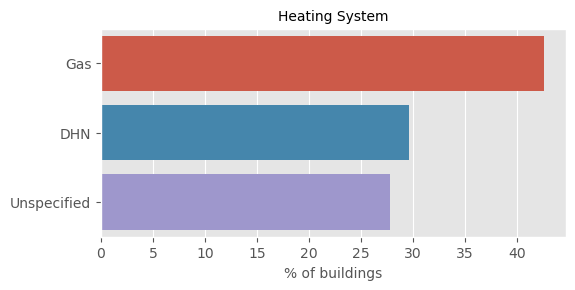

In [13]:
plot_data_heat_system = make_table_heating_system(district_mon.buildings)  
# with plt.style.use('ggplot'):
f, ax = plt.subplots(figsize=(6, 2.7))
ax = sns.barplot(ax=ax, x='percent_of_buildings', y='name', data=plot_data_heat_system)
ax.set(
    title='Heating System',
    ylabel='', xlabel='% of buildings');

### Summary of building categories

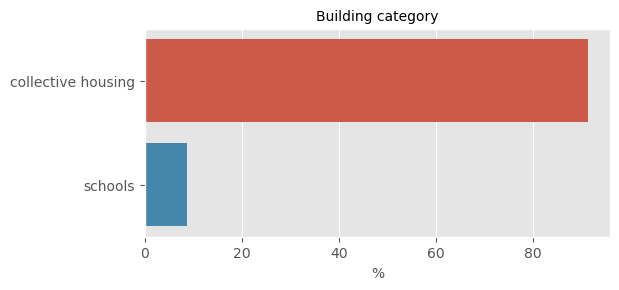

In [14]:
plot_data_sia_cat = make_table_cat_sia_surface( district_mon.buildings)
f, ax = plt.subplots(figsize=(6, 2.7))
ax = sns.barplot(ax=ax, x='percentage_era', y='name', data=plot_data_sia_cat)
ax.set(
    title='Building category',
    ylabel='', xlabel='%');

## Results

### Les Vergers - monitored annual heat demand

In [15]:
summary_measured = create_table_summarize(district_mon.load_curve, district_mon.buildings)
summary_measured.style.format(precision=2)

### Les Vergers - Tessa model

In [16]:
vergers_egids = pd.read_csv("vergers_egid.csv", sep=",")
district_tes = District.from_ids(vergers_egids.egid.to_list(),
                                               building_data_source=app.building_data_source, 
                                               climate_data_source=app.climate_data_source, 
                                               heat_model=app.heat_model, gen_load_curves=True)

In [17]:
buildings = district_tes.buildings.copy()
hourly_load_curve = district_tes.load_curve.copy()

In [18]:
summary_tessa  = create_table_summarize(district_tes.load_curve, district_tes.buildings)
summary_tessa.style.format(precision=2)

### Comparison between data and modelled heat demands

Tessa overestimates demand relative to the provided monitoring data by 20% on average. However there is a big difference between hot water and space heating, with space heating being considerably more accurate at 5% over estimation.

In [19]:
comparison = 100 * (summary_tessa - summary_measured) / summary_measured
comparison.columns = ['Pmax [%]', 'Yearly Heat demand [%]', 'Full Load Hours [%]', 'CO2 [%]']

In [20]:
comparison.style.format(precision=2)

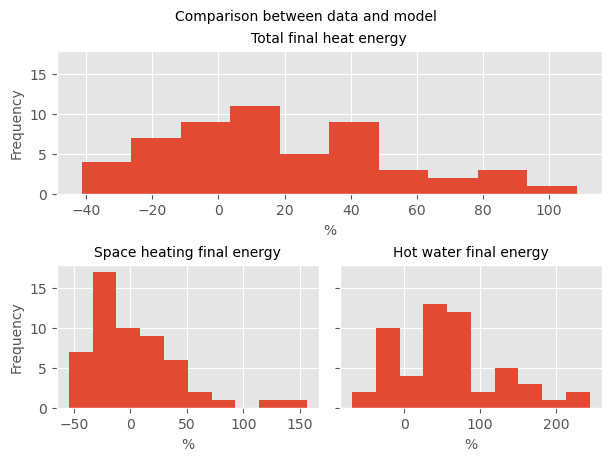

In [21]:
f, axs = plt.subplot_mosaic([['top', 'top'],
                             ['lower left', 'lower right']], 
                            layout="constrained", 
                            sharey=True,
                            figsize=(6, 4.5))
                              
ax = axs['top']

ax = ((100*(district_tes.buildings.q_hww_final_kwh - district_mon.buildings.q_hww_final_kwh) /
  district_mon.buildings.q_hww_final_kwh)
 .plot.hist(ax=ax,
           title='Total final heat energy',
      xlabel='%')
)
ax.set(xlabel='%')

# ax = axs[0]
ax = axs['lower left']
((100*(district_tes.buildings.q_h_final_kwh - district_mon.buildings.q_h_final_kwh) /
  district_mon.buildings.q_h_final_kwh)
 .plot.hist(ax=ax,
           title='Space heating final energy',
      xlabel='%')
)
ax.set(xlabel='%')

# ax = axs[1]
ax = axs['lower right']
((100*(district_tes.buildings.q_ww_final_kwh - district_mon.buildings.q_ww_final_kwh) /
  district_mon.buildings.q_ww_final_kwh)
 .plot.hist(ax=ax, 
            title='Hot water final energy')
)
ax.set(xlabel='%')

f.suptitle('Comparison between data and model');

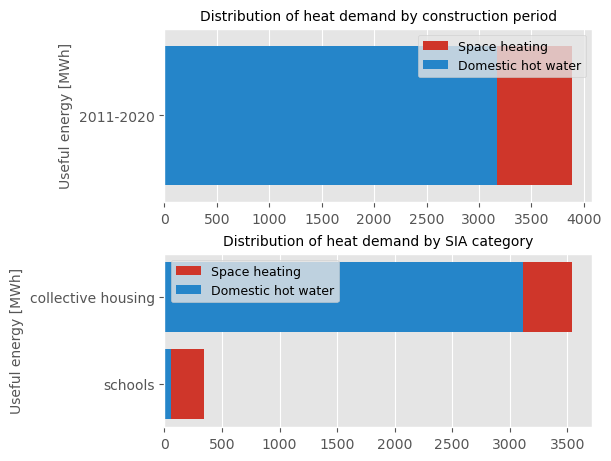

In [22]:
plot_histo_cat_sia_construction_demand(district_tes.buildings)

### Summary of district characteristics

In [23]:
table_district_summary(district_mon)

In [24]:
total_surface_tessa = buildings['era'].sum()
total_surface_heated = buildings.loc[buildings['is_heated'] == True, 'era'].sum()
percentage_heated = total_surface_heated / total_surface_tessa * 100
total_surface = buildings['total_surface'].sum()
percentage_era_tessa = total_surface_tessa / total_surface * 100

percentage_fossil = calc_percent_fossil_heat(buildings)

total_ecs_GWh = buildings['q_ww_kwh'].sum()/ (1000*1000)
total_heat_demand_GWh = buildings['q_hww_kwh'].sum()/ (1000*1000)
percentage_ecs = total_ecs_GWh / total_heat_demand_GWh * 100
hours_without_heating = (hourly_load_curve['p_h_kw'] == 0).sum()
perce_without_heating = hours_without_heating / 8760 * 100
total_t_co2_before = buildings['co2eq_hww_kg'].sum() / 1000

chap_2_1_6 = f"""
The mean CO2 emission intensity by built area is {summary_measured.loc["Total",'CO2 [t. eq.]']/total_surface*1000:.0f} kg CO2/m2.year.
"""
display(Markdown(chap_2_1_6))

chap_2_1_2 = f"""
<p style='text-align: justify;'>
According to public data, {percentage_fossil:.1f} % of buildings are supplied with fossil energy (gas and oil), 
however in theory all buildings should have already been connected to district heating. This shows that the RegBL data is not up to date.
The large percentage of buildings considered as having an "unspecified" boiler can be explained by the fact that the Vergers district is recent (2015)</p>
"""
display(Markdown(chap_2_1_2))




The mean CO2 emission intensity by built area is 12 kg CO2/m2.year.



<p style='text-align: justify;'>
According to public data, 42.6 % of buildings are supplied with fossil energy (gas and oil), 
however in theory all buildings should have already been connected to district heating. This shows that the RegBL data is not up to date.
The large percentage of buildings considered as having an "unspecified" boiler can be explained by the fact that the Vergers district is recent (2015)</p>


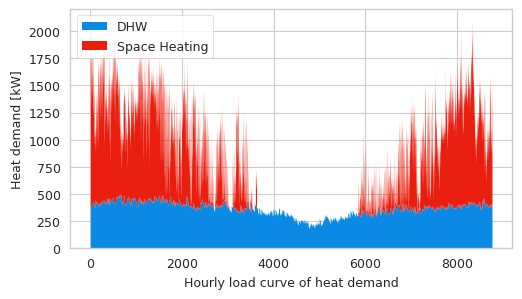

In [25]:
plot_area_load_curve(hourly_load_curve)

### District heating

The map below shows the route of the modelled heating network

In [26]:
flow = FlowProperties()
costs = NetworkCosts()
dat = app.district_network_builder.get_heat_source_data(code='ashp')
dat = dat | {'power_useful': 2000}
heat_sources = ThermalSources(sources=[ThermalSource(**dat)])
thermal_net = app.district_network_builder.for_district_single(district_tes, 
                                                    flow=flow,
                                                    costs=costs,
                                                     heat_sources=heat_sources,
                                                     load_geom=True
                                                     )

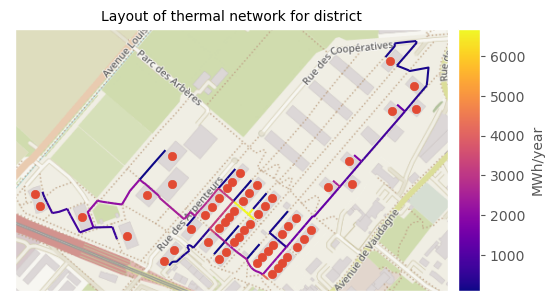

In [27]:
buildings_plot = gpd.GeoDataFrame.from_features(district_mon.buildings.__geo_interface__, crs=4326).to_crs(epsg=3857)
pipes_plot = gpd.GeoDataFrame.from_features(thermal_net.geometry, crs=4326).to_crs(epsg=3857)

pipes_plot['heat_total_plot'] = pipes_plot.heat_total / 1000
vmin, vmax = pipes_plot.heat_total_plot.quantile([0.03, 0.97]).values

fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
ax = buildings_plot.plot( ax=ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax = pipes_plot.plot(column='heat_total_plot', cmap='plasma', legend=True,
                     vmin=vmin, vmax=vmax,
                     ax=ax, cax=cax)
cax.set(ylabel='MWh/year')
cx.add_basemap(ax, zoom=16, source=cx.providers.OpenStreetMap.HOT, attribution=False)
ax.grid(False)
ax.set(title='Layout of thermal network for district',xticks=[], yticks=[]);

#### Summary of network costs

In [28]:
dn_dat = thermal_net.summary

dn_cost_table = [
    ("Levelised Cost of Energy", f"{dn_dat['lcoh']:.2f} CHF/kWh"),
    ("Annualized cost of network pipes", f"{dn_dat['annualised_cost_per_m']:.2f} CHF/m"),
    ("Total investment", f"{dn_dat['total_investment_cost']/1000:.0f} kCHF" ),
    ("Total investment pipes", f"{dn_dat['investment_cost_pipe']/1000:.0f} kCHF" ),

    
]
pd.DataFrame(dn_cost_table, columns=['Description', 'Result']).set_index('Description')

Result
Description                                   
Levelised Cost of Energy          0.10 CHF/kWh
Annualized cost of network pipes   21.34 CHF/m
Total investment                     4065 kCHF
Total investment pipes               1205 kCHF

#### Summary of network physical characteristics

In [29]:
dn_dat = thermal_net.summary
dn_table = [
    ("Network length", f"{dn_dat['total_distance']:.0f} m"),
    ("Average demand density", f"{dn_dat['mean_linear_heat_density']:.0f} kWh/m.year"),
    ("Average pipe diameter", f"{dn_dat['mean_pipe_diameter']*1000:.0f}mm"),
    ("Max pipe diameter", f"{dn_dat['max_pipe_diameter']*1000:.0f}mm")
    
]
pd.DataFrame(dn_table, columns=['Description', 'Result']).set_index('Description')

Result
Description                            
Network length                   2444 m
Average demand density  2888 kWh/m.year
Average pipe diameter              50mm
Max pipe diameter                 137mm

#### Summary of selected heat sources for the thermal networks.

In [30]:
_make_heat_source_display_table(thermal_net.heat_sources.summary)

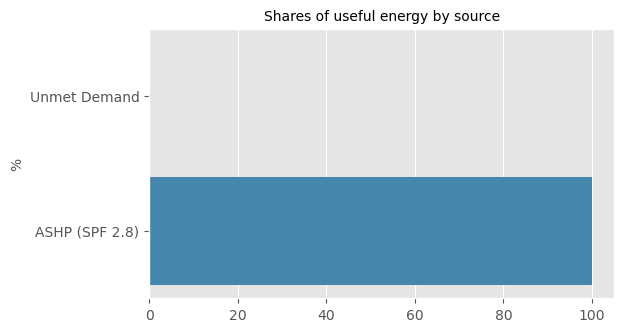

In [31]:
hs_energy = thermal_net.heat_sources.summary
ax = sns.barplot(y=[r['name'] for r in reversed(hs_energy)],
                 x=[r['percent_energy_useful'] * 100 for r in reversed(hs_energy)])
ax.set(title='Shares of useful energy by source',  ylabel='%');

#### Emissions and energy savings from thermal network 
Note that CO2 for pumping electricity has not been taken into account.


In [32]:
sum_cols = ['q_hww_kwh', 'q_hww_final_kwh', 'co2eq_hww_kg', 'p_hww_max1d_kw']
tots = buildings.reindex(columns=sum_cols)[sum_cols].sum()

ntht = table_network_heat_summary(thermal_net)

# Savings
savings = {
    'final_energy_saving': tots['q_hww_final_kwh'] - ntht['energy_final'],
    'co2_saving': tots['co2eq_hww_kg'] - ntht['co2_eq_total'],
    'co2_saving_pct': (tots['co2eq_hww_kg'] - ntht['co2_eq_total']) / tots['co2eq_hww_kg'],
}

table = pd.DataFrame(
    [
        ['Energy saved', f"{fmt_dv(savings['final_energy_saving'], dv['energy_useful']):.2f~}"],
        ['CO2 saved', f"{fmt_dv(savings['co2_saving'], dv['co2_eq_total']):.2f~}"],
        ['CO2 saved (%)', f"{savings['co2_saving_pct'] * 100:.0f} %"],
    ],
    columns=['Description', ' '],
).set_index('Description')
table.index.name = None
district_net_savings_table_styled = _base_table_style(table)

district_net_savings_table_styled

## Conclusion

Significant CO2 and cost savings are possible thanks to the use of a district network supplied by an ASHP.